# setup

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Training

In [4]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[['petal length (cm)','petal width (cm)']].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2,random_state=42)
tree_clf.fit(X_iris,y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [5]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  # path differs in the book
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

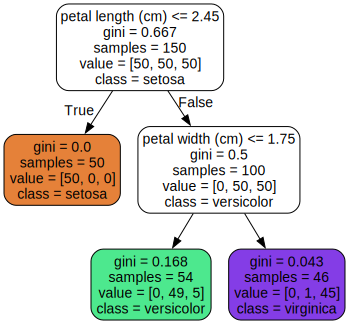

In [6]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot")  # path differs in the book

In [7]:
"""Graphviz also provides the dot command line tool to convert .dot files to a variety of formats. The following command converts the dot file to a png image:"""
# extra code
!dot -Tpng {IMAGES_PATH / "iris_tree.dot"} -o {IMAGES_PATH / "iris_tree.png"}

# Making Preds
>NOTE:
One of the many qualities of decision trees is that they require very little data preparation. In fact, they
don’t require feature scaling or centering at all.

1) A node’s samples attribute counts how many training instances it applies to.

2)  A node’s value attribute tells you how many training instances of each class this node
applies to: for example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor,
and 45 Iris virginica.

3) a node’s gini attribute measures its Gini impurity: a node
is “pure” (gini=0) if all training instances it applies to belong to the same class.

# Gini Impurity Formula

The Gini impurity is calculated as:

$$
G_i = 1 - \sum_{k=1}^{n} p_{i,k}^2
$$

### In this equation:
- \( G_i \): The Gini impurity of the \( i \)-th node.
- \( p_{i,k} \): The ratio of class \( k \) instances among the training instances in the \( i \)-th node.

>NOTE:
Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split
nodes always have exactly two children (i.e., questions only have yes/no answers). However, other
algorithms, such as ID3, can produce decision trees with nodes that have more than two children.

4) Decision tree decision boundaries:
The thick vertical line
represents the decision boundary of the root node (depth 0): petal length = 2.45 cm.
Since the lefthand area is pure (only Iris setosa), it cannot be split any further.
However, the righthand area is impure, so the depth-1 right node splits it at petal width
= 1.75 cm (represented by the dashed line). Since max_depth was set to 2, the decision
tree stops right there. If you set max_depth to 3, then the two depth-2 nodes would each
add another decision boundary (represented by the two vertical dotted lines).

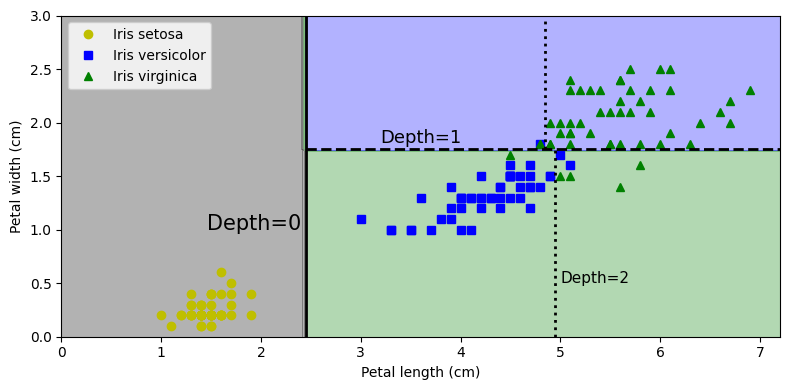

In [8]:
#code for decision boundary:
from matplotlib.colors import ListedColormap
#custom color mapping for different classes
custom_cmap = ListedColormap(['black','green','blue'])
plt.figure(figsize=(8,4))


import numpy as np
#meshgrid of creates grid of lengths(x-axis) & widths(y-axis) for plotting decision boundaries over the entire feature space.
lengths,widths = np.meshgrid(np.linspace(0,7.2,100),np.linspace(0,3,100))

#np.c_ : combines these 2D array of shape (10000,2) (each row repr a pair of petal length and width)
X_iris_all = np.c_[lengths.ravel(),widths.ravel()]

#predict class for each grid point and reshape preds into a 2D array matching the grid's shape.
y_pred = tree_clf.predict(X_iris_all).reshape(lengths.shape)

#Fills the grid with colour corresponding to the predicted clases using the custom colormap
plt.contourf(lengths,widths,y_pred,alpha=0.3,cmap=custom_cmap)

#plotting iris dataset points:
for idx, (name,style) in enumerate(zip(iris.target_names,("yo","bs","g^"))):
    plt.plot(X_iris[:,0][y_iris==idx],X_iris[:,1][y_iris==idx],
             style,
             label=f"Iris {name}")
    
# train a deeper Decision Tree:
tree_clf_deeper = DecisionTreeClassifier(max_depth=3,random_state=42)
tree_clf_deeper.fit(X_iris,y_iris)

#Extract Decision Thresholds: 0(depth=0,root node), 2(depth=1,left node) , 3(depth=2,left node), 6(depth=2,right node)
th0,th1,th2a,th2b = tree_clf_deeper.tree_.threshold[[0,2,3,6]] 

# Plot Decision Lines and Annotations:
#Draw vertical (x=th0,x=th2a,x=th2b) and horizontal(y=th1) lines repr decision boundaries for depth 0,1,2.
# line styles ("-","--",":") indicate the depth of the decision.
plt.plot([th0,th0],[0,3],"k-",linewidth=2)
plt.plot([th0,7.2],[th1,th1],"k--",linewidth=2)
plt.plot([th2a,th2a],[0,th1],"k:",linewidth=2)
plt.plot([th2b,th2b],[th1,3],"k:",linewidth=2)

#Anotates decision depths(labels) at appropriate positions so it doesn't overlaps
plt.text(th0-0.05,1.0,"Depth=0",horizontalalignment="right",fontsize=15)
plt.text(3.2,th1+0.02,"Depth=1",verticalalignment="bottom",fontsize=13)
plt.text(th2a + 0.05,0.5,"Depth=2",fontsize=11)

#customize and save the plot:
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0,7.2,0,3])
plt.legend()
save_fig("decision_tree_decision_boundaries_plot")

plt.show()


>MODEL INTERPRETATION: WHITE BOX VERSUS BLACK BOX:
Decision trees are intuitive, and their decisions are easy to interpret. Such models
are often called white box models. In contrast, as you will see, random forests and
neural networks are generally considered black box models. They make great
predictions, and you can easily check the calculations that they performed to make
these predictions; nevertheless, it is usually hard to explain in simple terms why the
predictions were made. For example, if a neural network says that a particular
person appears in a picture, it is hard to know what contributed to this prediction:
Did the model recognize that person’s eyes? Their mouth? Their nose? Their shoes?
Or even the couch that they were sitting on? Conversely, decision trees provide
nice, simple classification rules that can even be applied manually if need be (e.g.,
for flower classification). The field of interpretable ML aims at creating ML
systems that can explain their decisions in a way humans can understand. This is
important in many domains—for example, to ensure the system does not make
unfair decisions.

In [9]:
tree_clf.tree_

In [12]:
import sklearn.tree
help(sklearn.tree._tree.Tree)

Help on class Tree in module sklearn.tree._tree:

class Tree(builtins.object)
 |  Array-based representation of a binary decision tree.
 |  
 |  The binary tree is represented as a number of parallel arrays. The i-th
 |  element of each array holds information about the node `i`. Node 0 is the
 |  tree's root. You can find a detailed description of all arrays in
 |  `_tree.pxd`. NOTE: Some of the arrays only apply to either leaves or split
 |  nodes, resp. In this case the values of nodes of the other type are
 |  arbitrary!
 |  
 |  Attributes
 |  ----------
 |  node_count : intp_t
 |      The number of nodes (internal nodes + leaves) in the tree.
 |  
 |  capacity : intp_t
 |      The current capacity (i.e., size) of the arrays, which is at least as
 |      great as `node_count`.
 |  
 |  max_depth : intp_t
 |      The depth of the tree, i.e. the maximum depth of its leaves.
 |  
 |  children_left : array of intp_t, shape [node_count]
 |      children_left[i] holds the node id of the

# Estimating Class Probabilities:
A decision tree can also estimate the probability that an instance belongs to a particular
class k. First it traverses the tree to find the leaf node for this instance, and then it
returns the ratio of training instances of class k in this node.
For example, suppose you
have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding
leaf node is the depth-2 left node, so the decision tree outputs the following
probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for
Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris versicolor
(class 1) because it has the highest probability

In [13]:
tree_clf.predict_proba([[5,1.5]]).round(3)


array([[0.   , 0.907, 0.093]])

In [14]:
tree_clf.predict([[5,1.5]])

array([1])

# The CART Training Algorithm:
1) Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train
decision trees (also called “growing” trees). The algorithm works by first splitting the
training set into two subsets using a single feature k and a threshold t (e.g., “petal
length ≤ 2.45 cm”). How does it choose k and t ? It searches for the pair (k, t ) that
produces the purest subsets, weighted by their size. Equation 6-2 gives the cost function
that the algorithm tries to minimize.

# CART cost function for classification:
$$
J(k, t_k) = \frac{m_{\text{left}}}{m} G_{\text{left}} + \frac{m_{\text{right}}}{m} G_{\text{right}}
$$

### Where:
- \( G_{\text{left}} / G_{\text{right}} \): Measures the impurity of the left/right subset.
- \( m_{\text{left}} / m_{\text{right}} \): Number of instances in the left/right subset.
- \( m \): Total number of instances in the node.

2) Once the CART algorithm has successfully split the training set in two, it splits the
subsets using the same logic, then the sub-subsets, and so on, recursively. It stops
recursing once it reaches the maximum depth (defined by the max_depth
hyperparameter), or if it cannot find a split that will reduce impurity. A few other
hyperparameters (described in a moment) control additional stopping conditions:
min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and
max_leaf_nodes.

>WARNING:
As you can see, the CART algorithm is a greedy algorithm: it greedily searches for an optimum split at
the top level, then repeats the process at each subsequent level. It does not check whether or not the split
will lead to the lowest possible impurity several levels down. A greedy algorithm often produces a
solution that’s reasonably good but not guaranteed to be optimal.
Unfortunately, finding the optimal tree is known to be an NP-complete problem. It requires O(exp(m))
time, making the problem intractable even for small training sets. This is why we must settle for a
“reasonably good” solution when training decision trees.

# Computational Complexity:

1) The training algorithm compares all features (or less if max_features is set) on all
samples at each node. Comparing all features on all samples at each node results in a
training complexity of O(n × m log (m)).

2) Making predictions requires traversing the decision tree from the root to a leaf.
Decision trees generally are approximately balanced, so traversing the decision tree
requires going through roughly O(log_2 (m)) nodes, where log_2 (m) is the binary
logarithm of m, equal to log(m) / log(2). Since each node only requires checking the
value of one feature, the overall prediction complexity is O(log_2(m)), independent of
the number of features. So predictions are very fast, even when dealing with large
training sets.

# Gini Impurity or Entropy:

1) By default, the DecisionTreeClassifier class uses the Gini impurity measure, but
you can select the entropy impurity measure instead by setting the criterion
hyperparameter to "entropy". 
Entropy is zero when all messages are identical. In machine
learning, entropy is frequently used as an impurity measure: a set’s entropy is zero
when it contains instances of only one class

# Entropy Formula

The entropy is calculated as:

$$
H_i = - \sum_{k=1}^{n} p_{i,k} \log_2(p_{i,k}), \; \text{where } p_{i,k} \neq 0
$$

### Explanation:
- \( H_i \): The entropy of the \( i \)-th node.
- \( p_{i,k} \): The ratio of class \( k \) instances among the training instances in the \( i \)-th node.
- The condition \( p_{i,k} \neq 0 \) ensures we avoid undefined behavior in logarithms.

>TIP: 
So, should you use Gini impurity or entropy? The truth is, most of the time it does not
make a big difference: they lead to similar trees. Gini impurity is slightly faster to
compute, so it is a good default. However, when they differ, Gini impurity tends to
isolate the most frequent class in its own branch of the tree, while entropy tends to
produce slightly more balanced trees.

# Regularization Hyperparameters: 

1) Decision trees make very few assumptions about the training data (as opposed to linear
models, which assume that the data is linear, for example). If left unconstrained, the
tree structure will adapt itself to the training data, fitting it very closely—indeed, most
likely overfitting it. Such a model is often called a nonparametric model, not because it
does not have any parameters (it often has a lot) but because the number of parameters
is not determined prior to training, so the model structure is free to stick closely to the
data. In contrast, a parametric model, such as a linear model, has a predetermined
number of parameters, so its degree of freedom is limited, reducing the risk of
overfitting (but increasing the risk of underfitting).

2) The DecisionTreeClassifier class has a few other parameters that similarly restrict
the shape of the decision tree:

>max_features
Maximum number of features that are evaluated for splitting at each node

>max_leaf_nodes
Maximum number of leaf nodes

>min_samples_split
Minimum number of samples a node must have before it can be split

>min_samples_leaf
Minimum number of samples a leaf node must have to be created

>min_weight_fraction_leaf
Same as min_samples_leaf but expressed as a fraction of the total number of

>weighted instances
Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize
the model.

>NOTE:
Other algorithms work by first training the decision tree without restrictions, then pruning (deleting)
unnecessary nodes. A node whose children are all leaf nodes is considered unnecessary if the purity
improvement it provides is not statistically significant. Standard statistical tests, such as the χ test (chisquared test), are used to estimate the probability that the improvement is purely the result of chance
(which is called the null hypothesis). If this probability, called the p-value, is higher than a given
threshold (typically 5%, controlled by a hyperparameter), then the node is considered unnecessary and
its children are deleted. The pruning continues until all unnecessary nodes have been pruned.

# Classification: 

In [4]:
# Let’s test regularization on the moons dataset,We’ll train one decision tree without regularization,
#  and another with min_samples_leaf=5

from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier

X_moons,y_moons = make_moons(n_samples=150,noise=0.2,random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42) #no regularization
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5,random_state=42)  # with regularization
tree_clf1.fit(X_moons,y_moons)
tree_clf2.fit(X_moons,y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

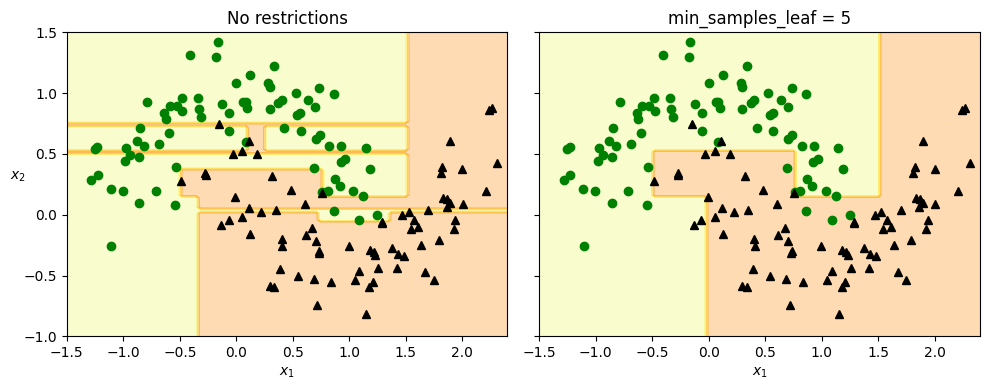

In [9]:
#Decision boundary code:
import matplotlib.pyplot as plt
import numpy as np
def plot_decision_boundary(clf,X,y,axes,cmap):

    #Creates a grid of points in the specified range (defined by axes)
    #np.linspace divides the range into 100 intervals for both x1 & x2
    x1,x2  = np.meshgrid(np.linspace(axes[0],axes[1],100),
                         np.linspace(axes[2],axes[3],100))
    
    #combines x1 & x2 into a single 2D array of coordinates (X_new) to evaluate the classifier on.
    X_new = np.c_[x1.ravel(),x2.ravel()]

    #use the clf to predict class labels for each grid point and reshapes the preds to match the shape of x1,x2.
    y_pred = clf.predict(X_new).reshape(x1.shape)

    #plots the decision regions using filled contours,colored based on predictions.
    plt.contourf(x1,x2,y_pred,alpha=0.3,cmap=cmap)
    colors = {"Wistia": ["green","black"],"Pastel1":["red","blue"]}
    markers = ("o","^")
    
    # plot data points: iterates thru the classes (idx=0,1) & plots the data points corresponding to each class with specific colors and markets.
    for idx in (0,1):
        plt.plot(X[:,0][y==idx],X[:,1][y==idx],
                 color = colors[cmap][idx],
                 marker = markers[idx],
                 linestyle='none')
    
    #set plot properties: sets axis ranges and labels for better visualization.
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$",rotation=0)


#creates a fig with 2 subplots arranged horizontally(ncols=2)
# the subplots share the same y-axis (sharey=True)
fig,axes = plt.subplots(ncols=2,figsize=(10,4),sharey=True)

#plotting decision boundaries:

#for clf1
plt.sca(axes[0]) # focuses on the 1st subplot
plot_decision_boundary(tree_clf1,X_moons,y_moons,
                       axes=[-1.5,2.4,-1,1.5],
                       cmap="Wistia")
plt.title("No restrictions")

#for clf2
plt.sca(axes[1]) # focuses on 2nd subplot.
plot_decision_boundary(tree_clf2,X_moons,y_moons,
                       axes=[-1.5,2.4,-1,1.5],
                       cmap='Wistia')
plt.title(f"min_samples_leaf = {tree_clf2.min_samples_leaf}")
plt.ylabel("") #don't need to label y axis for 2nd plot

save_fig("min_samples_leaf_plot") #save with helper function

plt.show()

# Insights:
left is overfitting and right model will proabably generalize better.

we can verify this by evaluating both trees on a test set generated using a different random seed.

In [15]:
X_moons_test,y_moons_test  = make_moons(n_samples=1000,
                                        noise=0.2,
                                        random_state=43)
print(tree_clf1.score(X_moons_test,y_moons_test))
print(tree_clf2.score(X_moons_test,y_moons_test))



0.898
0.92


# Regression:

In [12]:
# s build a regression
# tree using Scikit-Learn’s DecisionTreeRegressor class, training it on a noisy
# quadratic dataset with max_depth=2.

import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X_quad = np.random.rand(200,1) - 0.5 #a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200,1)

tree_reg = DecisionTreeRegressor(max_depth=2,random_state=42)
tree_reg.fit(X_quad,y_quad)


tree_reg2 = DecisionTreeRegressor(max_depth=3,random_state=42)
tree_reg2.fit(X_quad,y_quad)

DecisionTreeRegressor(max_depth=3, random_state=42)

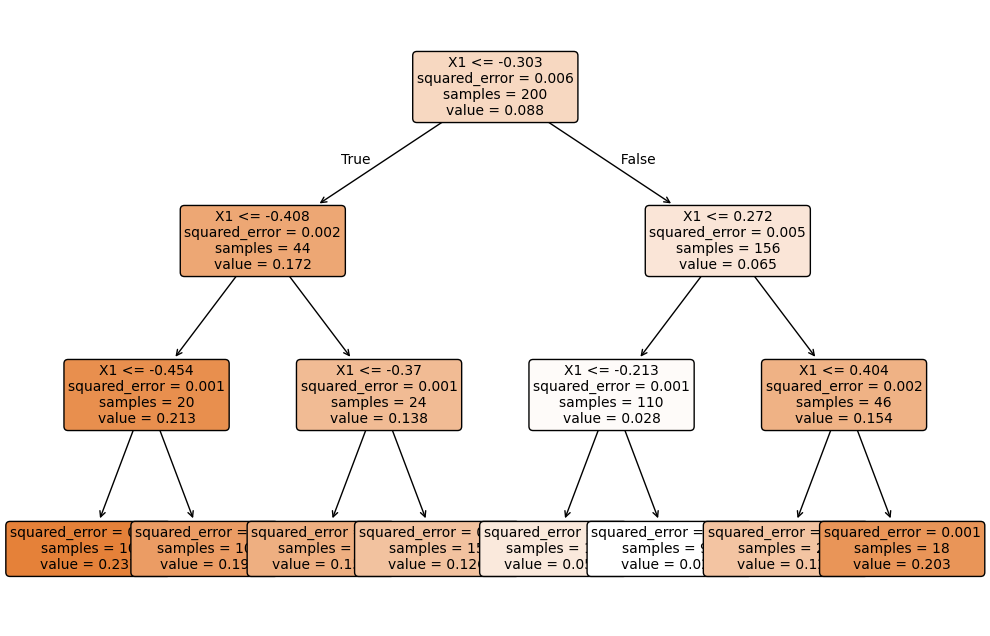

In [13]:
# plot the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(tree_reg2,
          feature_names=['X1'],
          rounded=True,
          filled=True,
          fontsize=10)
plt.show()

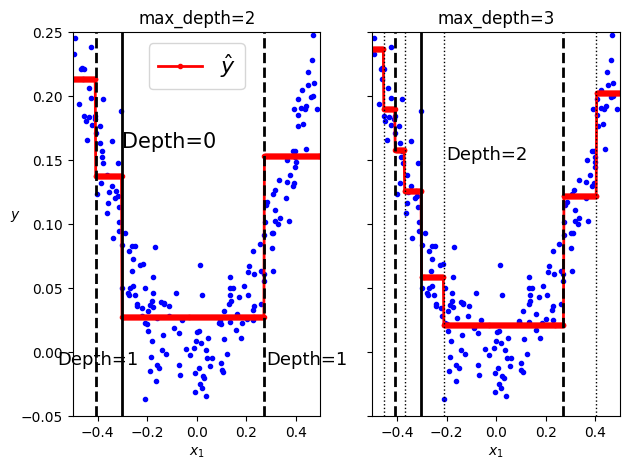

In [ ]:
#code for generating fig 6.5(preds of 2 decision tree regs models)

#helper function to plot reg preds: axes: Axis limits for the plot [x_min,x_max,y_min,y_max]
def plot_regression_predictions(tree_reg,X,y,axes=[-0.5,0.5,-0.05,0.25]):
    
    #creates 500 evenly spaced points b/w axes[0],axes[1] for prediction.
    x1 = np.linspace(axes[0],axes[1],500).reshape(-1,1)
    
    #predicts the traget values for the generated points
    y_pred = tree_reg.predict(x1)

    # set plot properties
    plt.axis(axes)
    plt.xlabel("$x_1$")
    plt.plot(X,y,"b.")
    plt.plot(x1,y_pred,"r.-",linewidth=2,label=r"$\hat{y}$")


# create 2 subplots, one for eacch model
fig,axes= plt.subplots(ncols=2,figure=(10,4),sharey=True)

#plot for tree_reg
plt.sca(axes[0])
plot_regression_predictions(tree_reg,X_quad,y_quad)

#retrieves the thresholds (splits) of the tree at specific nodes:
# th0 = root node split(depth=0) and th1a & th1b: splits at depth1 for the left and right child nodes.
th0,th1a,th1b = tree_reg.tree_.threshold[[0,1,4]] #index 0 => root node split , 1 => left child of root node, 4=>This is the right child of the left node at depth=1

#plot vertical lines at the split positions: solid line for depth 0 split and dashed lines for depth 1 splits.
for split,style in ((th0,"k-"),(th1a,"k--"),(th1b,"k--")):
    plt.plot([split,split],[-0.05,0.25],style,linewidth=2)

#add text annotations:
plt.text(th0,0.16,"Depth=0",fontsize=15)
plt.text(th1a+0.01,-0.01,"Depth=1",horizontalalignment="center",fontsize=13)
plt.text(th1b+0.01,-0.01,"Depth=1",fontsize=13)
plt.ylabel("$y$",rotation=0)
plt.legend(loc="upper center",fontsize=16)
plt.title("max_depth=2")

# plot for tree_reg2
plt.sca(axes[1])

# retrieves and plots the thresholds for depth 2 splits as dotted lines
th2s = tree_reg2.tree_.threshold[[2,5,9,12]]
plot_regression_predictions(tree_reg2,X_quad,y_quad)

# plot vertical lines at the split positions: solid for depth 0 split and dashed lines for depth 1 splits
for split,style in ((th0,"k-"),(th1a,"k--"),(th1b,"k--")):
    plt.plot([split,split],[-0.05,0.35],style,linewidth=2)

#additional loop for depth 2
for split in th2s:
    plt.plot([split,split],[-0.05,0.25],"k:",linewidth=1)

# add text annotation:
plt.text(th2s[2]+0.01,0.15,"Depth=2",fontsize=13)
plt.title("max_depth=3")

save_fig("tree_regression_plot")
plt.show()

# Insights:
1) The main
difference is that instead of predicting a class in each node, it predicts a value.

2) This model’s predictions are represented on the left in Figure 6-5. If you set
max_depth=3, you get the predictions represented on the right. Notice how the
predicted value for each region is always the average target value of the instances in
that region. The algorithm splits each region in a way that makes most training
instances as close as possible to that predicted value.

The CART algorithm works as described earlier, except that instead of trying to split
the training set in a way that minimizes impurity, it now tries to split the training set in
a way that minimizes the MSE. Equation 6-4 shows the cost function that the algorithm
tries to minimize.

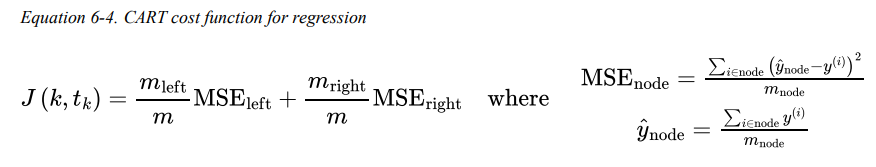

3) Just like for classification tasks, decision trees are prone to overfitting when dealing
with regression tasks.


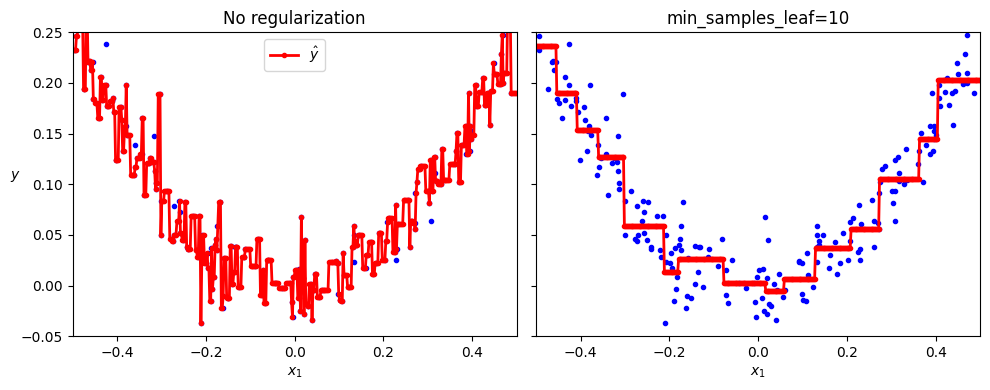

In [20]:
# figure 6.6 : preds of an unregularized reg tree (left) and regularized tree (right)
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42,min_samples_leaf=10)
tree_reg1.fit(X_quad,y_quad)
tree_reg2.fit(X_quad,y_quad)

x1 = np.linspace(-0.5,0.5,500).reshape(-1,1) #reshape into an 2d array
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig,axes = plt.subplots(ncols=2,figsize=(10,4),sharey=True)

# for tree_reg1
plt.sca(axes[0])
plt.plot(X_quad,y_quad,"b.")
plt.plot(x1,y_pred1,"r.-",linewidth=2,label=r"$\hat{y}$")
plt.axis([-0.5,0.5,-0.05,0.25])
plt.xlabel("$x_1$")
plt.ylabel("$y$",rotation=0)
plt.legend(loc="upper center")
plt.title("No regularization")

# for tree_reg2
plt.sca(axes[1])
plt.plot(X_quad,y_quad,"b.")
plt.plot(x1,y_pred2,"r.-",linewidth=2,label=r"$\hat{y}$")
plt.axis([-0.5,0.5,-0.05,0.25])
plt.xlabel("$x_1$")
plt.title(f"min_samples_leaf={tree_reg2.min_samples_leaf}")

save_fig("tree_regs_regularization_plot")
plt.show()


# Limitations and solutions:

1) Sensitivity to Axis Orientation:
>as you may have noticed, decision trees
love orthogonal decision boundaries (all splits are perpendicular to an axis), which
makes them sensitive to the data’s orientation. For example, Figure 6-7 shows a simple
linearly separable dataset: on the left, a decision tree can split it easily, while on the
right, after the dataset is rotated by 45°, the decision boundary looks unnecessarily
convoluted. Although both decision trees fit the training set perfectly, it is very likely
that the model on the right will not generalize well.

see fig 6.7

One way to limit this problem is to scale the data, then apply a principal component
analysis transformation. PCA rotates the data in a way that reduces the correlation between
the features, which often (not always) makes things easier for trees.



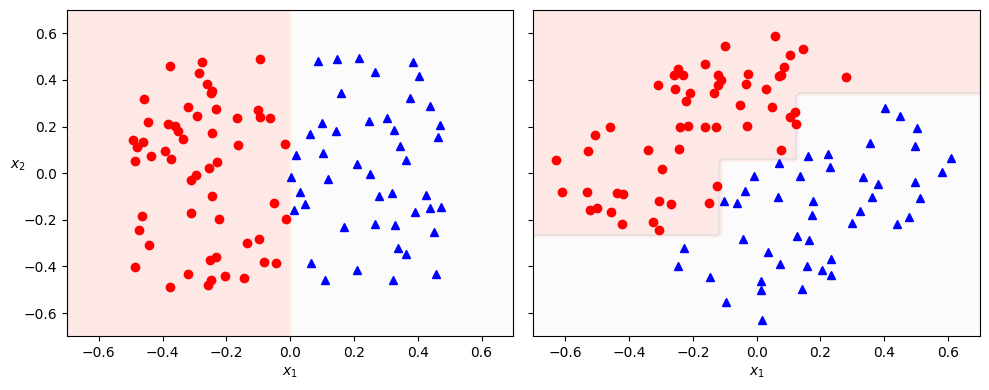

In [22]:
#figure 6.7: senstivity to training set orientations.

np.random.seed(6)
X_square = np.random.rand(100,2)-0.5
y_square = (X_square[:,0]>0).astype(np.int64)

angle = np.pi/4 #45 degree
rotation_matrix = np.array([[np.cos(angle),-np.sin(angle)],
                            [np.sin(angle),np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square,y_square)

tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square,y_square)

fig,axes = plt.subplots(ncols=2,figsize=(10,4),sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf_square,X_square,y_square,
                       axes = [-0.7,0.7,-0.7,0.7],cmap="Pastel1")

plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square,X_rotated_square,y_square,
                       axes=[-0.7,0.7,-0.7,0.7],cmap="Pastel1")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

In [26]:
# Let’s create a small pipeline that scales the data and rotates it using PCA, then train a
# DecisionTreeClassifier on that data.
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(
    StandardScaler(),
    PCA()
)
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2,random_state=42)
tree_clf_pca.fit(X_iris_rotated,y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

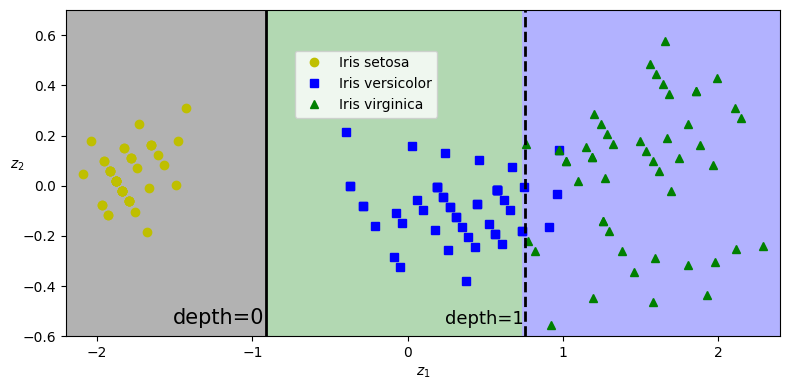

In [32]:
#fig 6-8: Decision boundaries on the scale PCA-rotated iris dataset
from sklearn.decomposition import PCA



plt.figure(figsize=(8,4))

axes = [-2.2,2.4,-0.6,0.7]
z0s,z1s = np.meshgrid(np.linspace(axes[0],axes[1],100),
                      np.linspace(axes[2],axes[3],100))
X_iris_pca_all= np.c_[z0s.ravel(),z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s,z1s,y_pred,alpha=0.3,cmap=custom_cmap)

for idx,(name,style) in enumerate(zip(iris.target_names,("yo","bs","g^"))):
    plt.plot(X_iris_rotated[:,0][y_iris==idx],
             X_iris_rotated[:,1][y_iris==idx],
             style,
             label=f"Iris {name}")
    
plt.xlabel("$z_1$")
plt.ylabel("$z_2$",rotation=0)
th1,th2 = tree_clf_pca.tree_.threshold[[0,2]]

plt.plot([th1,th1],axes[2:],"k-",linewidth=2)
plt.plot([th2,th2],axes[2:],"k--",linewidth=2)

plt.text(th1-0.01,axes[2]+0.05,"depth=0",
         horizontalalignment="right",fontsize=15)

plt.text(th2-0.01,axes[2]+0.05,"depth=1",
         horizontalalignment="right",fontsize=13)

plt.axis(axes)
plt.legend(loc=(0.32,0.67))

save_fig("pca_preprocessing_plot")

plt.show()

# insights:
1) Figure 6-8 shows the decision boundaries of
that tree: as you can see, the rotation makes it possible to fit the dataset pretty well
using only one feature, z , which is a linear function of the original petal length and
width.

see fig 6-8

2) Decision trees have a high Variance:
More generally, the main issue with decision trees is that they have quite a high
variance: small changes to the hyperparameters or to the data may produce very
different models. In fact, since the training algorithm used by Scikit-Learn is stochastic
—it randomly selects the set of features to evaluate at each node—even retraining the
same decision tree on the exact same data may produce a very different model, such as
the one represented in Figure 6-9 (unless you set the random_state hyperparameter).
As you can see, it looks very different from the previous decision tree (Figure 6-2).

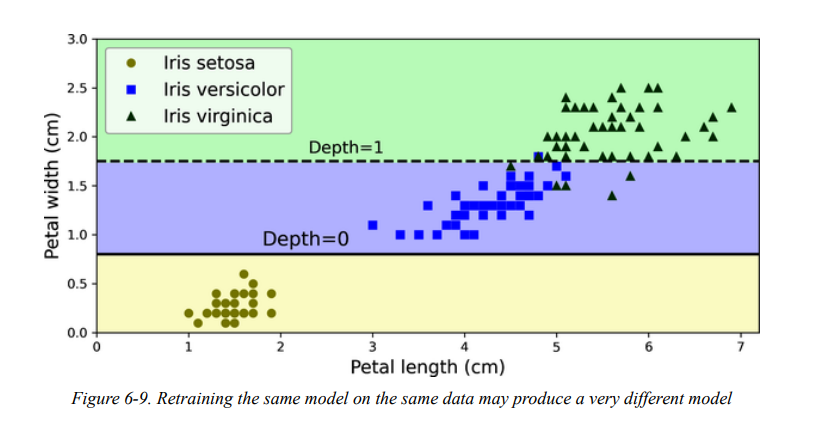




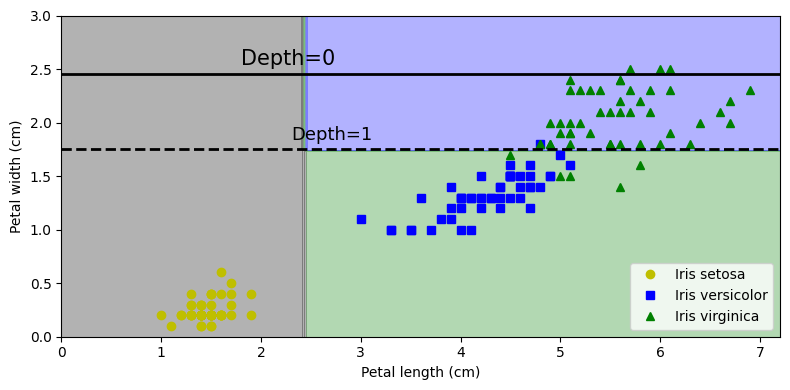

In [43]:
#  fig 6-9: Retraining the same model on the same data may produce a very different model
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2,random_state=42)
tree_clf_tweaked.fit(X_iris,y_iris)


plt.figure(figsize=(8, 4))
y_pred = tree_clf_tweaked.predict(X_iris_all).reshape(lengths.shape)
plt.contourf(lengths, widths, y_pred, alpha=0.3, cmap=custom_cmap)

for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris[:, 0][y_iris == idx], X_iris[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

th0, th1 = tree_clf_tweaked.tree_.threshold[[0, 2]]
plt.plot([0, 7.2], [th0, th0], "k-", linewidth=2)
plt.plot([0, 7.2], [th1, th1], "k--", linewidth=2)
plt.text(1.8, th0 + 0.05, "Depth=0", verticalalignment="bottom", fontsize=15)
plt.text(2.3, th1 + 0.05, "Depth=1", verticalalignment="bottom", fontsize=13)
plt.xlabel("Petal length (cm)")
plt.ylabel("Petal width (cm)")
plt.axis([0, 7.2, 0, 3])
plt.legend()
save_fig("decision_tree_high_variance_plot")

plt.show()

# Accessing the tree structure:


In [44]:
# A trained DecisionTreeClassifier has a tree_ attr that stores the tree's structure
tree = tree_clf.tree_
tree

In [49]:
#u can get the total number of nodes in the tree
tree.node_count
tree.max_depth
tree.max_n_classes
tree.n_outputs
tree.n_leaves

3

In [52]:
# all the info about the nodes is stored in numpy arrays.
tree.impurity
tree.children_left[0],tree.children_right[0]

#when lefft and right nodes are equal, it means this is a leaf node(and the children node ids are arbitrary)
tree.children_left[3],tree.children_right[3]


(-1, -1)

In [53]:
#u can get a leaf node like this:
is_leaf = (tree.children_left==tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

In [54]:
#non-leaf nodes are called split nodes. the feature they split is available via the feature array.
# values for leaf nodes should be ignored
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

In [55]:
# the corresponding thresholds are
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

In [56]:
#the no. of instances per class that reached each node is available too.
tree.value

array([[[0.33333333, 0.33333333, 0.33333333]],

       [[1.        , 0.        , 0.        ]],

       [[0.        , 0.5       , 0.5       ]],

       [[0.        , 0.90740741, 0.09259259]],

       [[0.        , 0.02173913, 0.97826087]]])

In [57]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

In [59]:
np.all(tree.value.sum(axis=(1,2))==tree.n_node_samples)

False

In [60]:
#compute depth of each node
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0,0)]
    while stack:
        node,node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node],node_depth +1))
            stack.append((tree.children_right[node],node_depth+1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

In [62]:
#get the thresholds of all split nodes at depth 1
tree_clf.tree_.feature[(depth==1)&(~is_leaf)]

array([1], dtype=int64)

In [63]:
tree_clf.tree_.threshold[(depth==1)&(~is_leaf)]

array([1.75])